# Use Graph Builder to create a dynamic workflow

## Introduction
In this tutorial, you will learn how to use `Graph Builder` in WorkGraph. The `Graph Builder` allow user to create a dynamic workflow based on the input value, as well as nested workflows.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## Workflow
Suppose we want to WorkGraph which include another WorkGraph`(x+y)*z` inside it.

### Create graph builder
We add `node.graph_builder` decorator to a function to define a graph builder node. The function create a WorkGraph based on the inputs, and returns the WorkGraph at the end.

In [2]:
from aiida_workgraph import task, WorkGraph

# define add node
@task.calcfunction()
def add(x, y):
    return x + y

# define multiply node
@task.calcfunction()
def multiply(x, y):
    return x*y


# use node.graph_builder decorator, expose the output of "multiply" node
# as the output of the `WorkGraph`.
@task.graph_builder(outputs = [["multiply.result", "result"]])
def add_multiply(x, y, z):
    # Create a WorkGraph
    wg = WorkGraph()
    wg.tasks.new(add, name="add", x=x, y=y)
    wg.tasks.new(multiply, name="multiply", x=z)
    wg.links.new(wg.nodes["add"].outputs[0], wg.nodes["multiply"].inputs["y"])
    # don't forget to return the `wg`
    return wg

### Create nested workflow
We can use the graph builder node inside another WorkGraph to create nested workflow. Here is an example:

In [3]:

from aiida_workgraph import WorkGraph
from aiida.orm import Int

wg = WorkGraph("test_graph_build")
# create a node using the graph builder
add_multiply1 = wg.tasks.new(add_multiply, x=Int(2), y=Int(3), z=Int(4))
add_multiply2 = wg.tasks.new(add_multiply, x=Int(2), y=Int(3))
# link the output of int node to the input of add node
wg.links.new(add_multiply1.outputs[0], add_multiply2.inputs["z"])
wg.submit(wait=True)

WorkGraph node created, PK: 19415


Generate node graph from the AiiDA process,and we can see that the `multiply` node is executed.

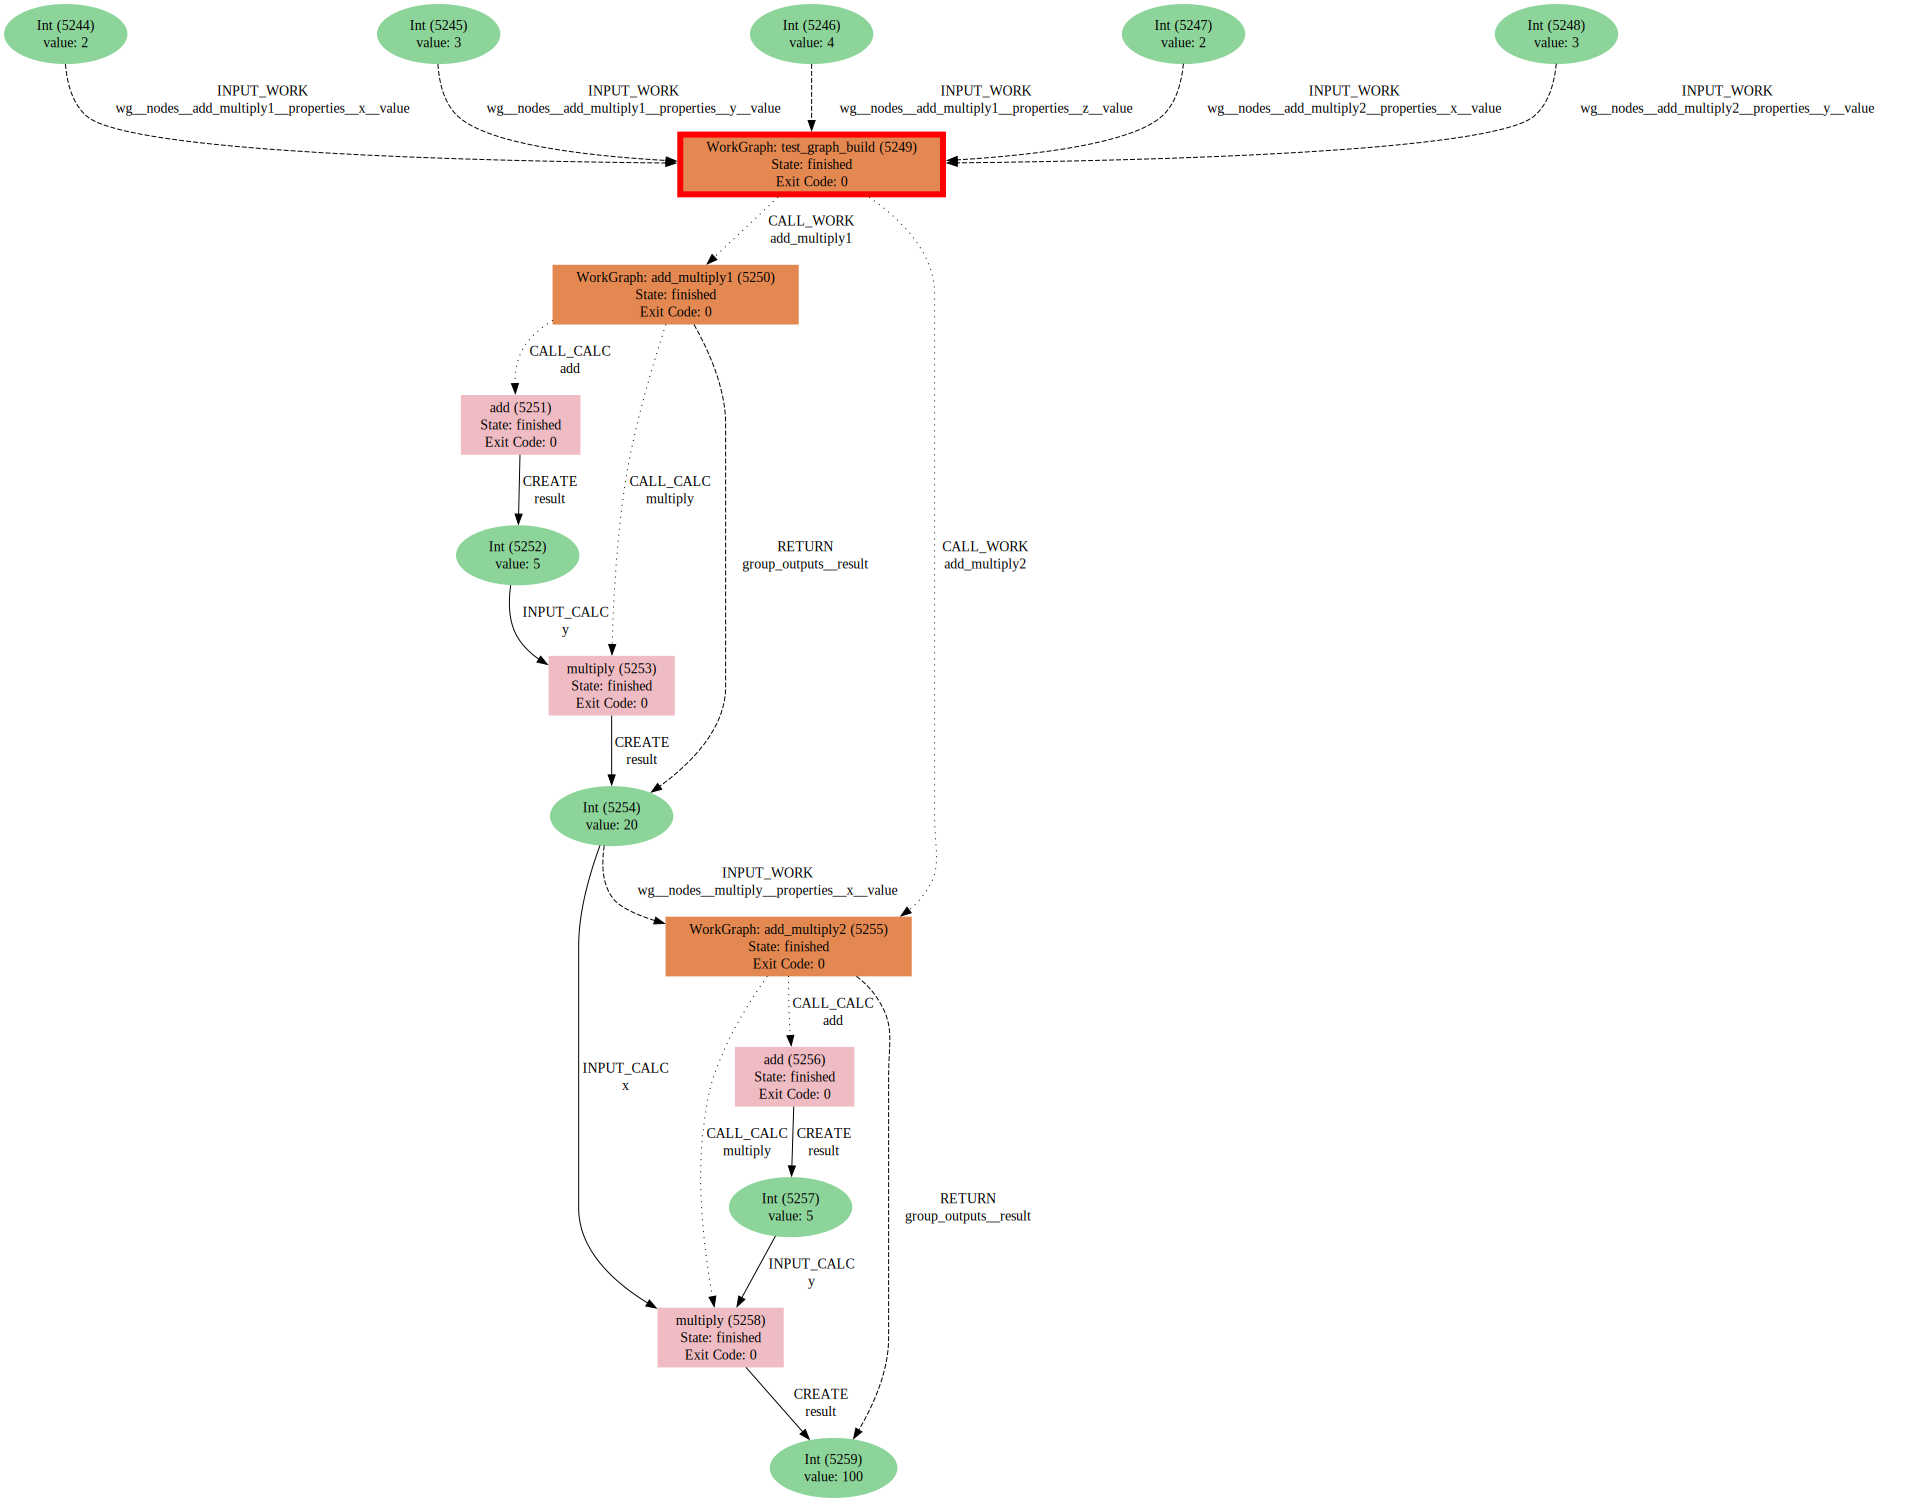

In [6]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

### Use the graph builder directly
Of course, one can use the graph builder directly to create a WorkGraph. Here is an example:

In [5]:
wg = add_multiply(2, 3, 4)
wg.submit(wait=True)

WorkGraph node created, PK: 10306


### Create the a Node from the workgraph (Advanced)
One can create a Node from a WorkGraph directly. The inputs and outputs of all nodes will be exposed by default.

In [17]:

from aiida_workgraph import WorkGraph, build_node
from aiida.orm import Int

wg1 = WorkGraph()
# note, one can not set the inputs values here using AiiDA data types
wg1.tasks.new(add, name="add")
wg1.tasks.new(multiply, name="multiply")
wg1.links.new(wg1.nodes["add"].outputs[0], wg1.nodes["multiply"].inputs["y"])

# create a node using the WorkGraph
AddMultiplyNode = build_node(wg1)
print("Inputs:")
for input in AddMultiplyNode().inputs:
    print(f"  - {input.name}")
print("Outputs:")
for output in AddMultiplyNode().outputs:
    print(f"  - {output.name}")

Inputs:
  - add
  - add.x
  - add.y
  - multiply
  - multiply.x
  - multiply.y
  - _wait
Outputs:
  - add
  - add.result
  - multiply
  - multiply.result
  - _outputs
  - _wait


Then we can use this Node inside a WorkGraph:

In [18]:
wg2 = WorkGraph("test_graph_build")
# create a node using the graph builder
add_multiply1 = wg2.tasks.new(AddMultiplyNode)
add_multiply1.set({"add": {"x": Int(2), "y": Int(3)}, "multiply": {"x": Int(4)}})
add_multiply2 = wg2.tasks.new(AddMultiplyNode)
add_multiply2.set({"add": {"y": Int(4)}, "multiply": {"x": Int(3)}})
# link the output of int node to the input of add node
wg2.links.new(add_multiply1.outputs["multiply.result"], add_multiply2.inputs["add.x"])

wg2.submit(wait=True)

WorkGraph node created, PK: 10422


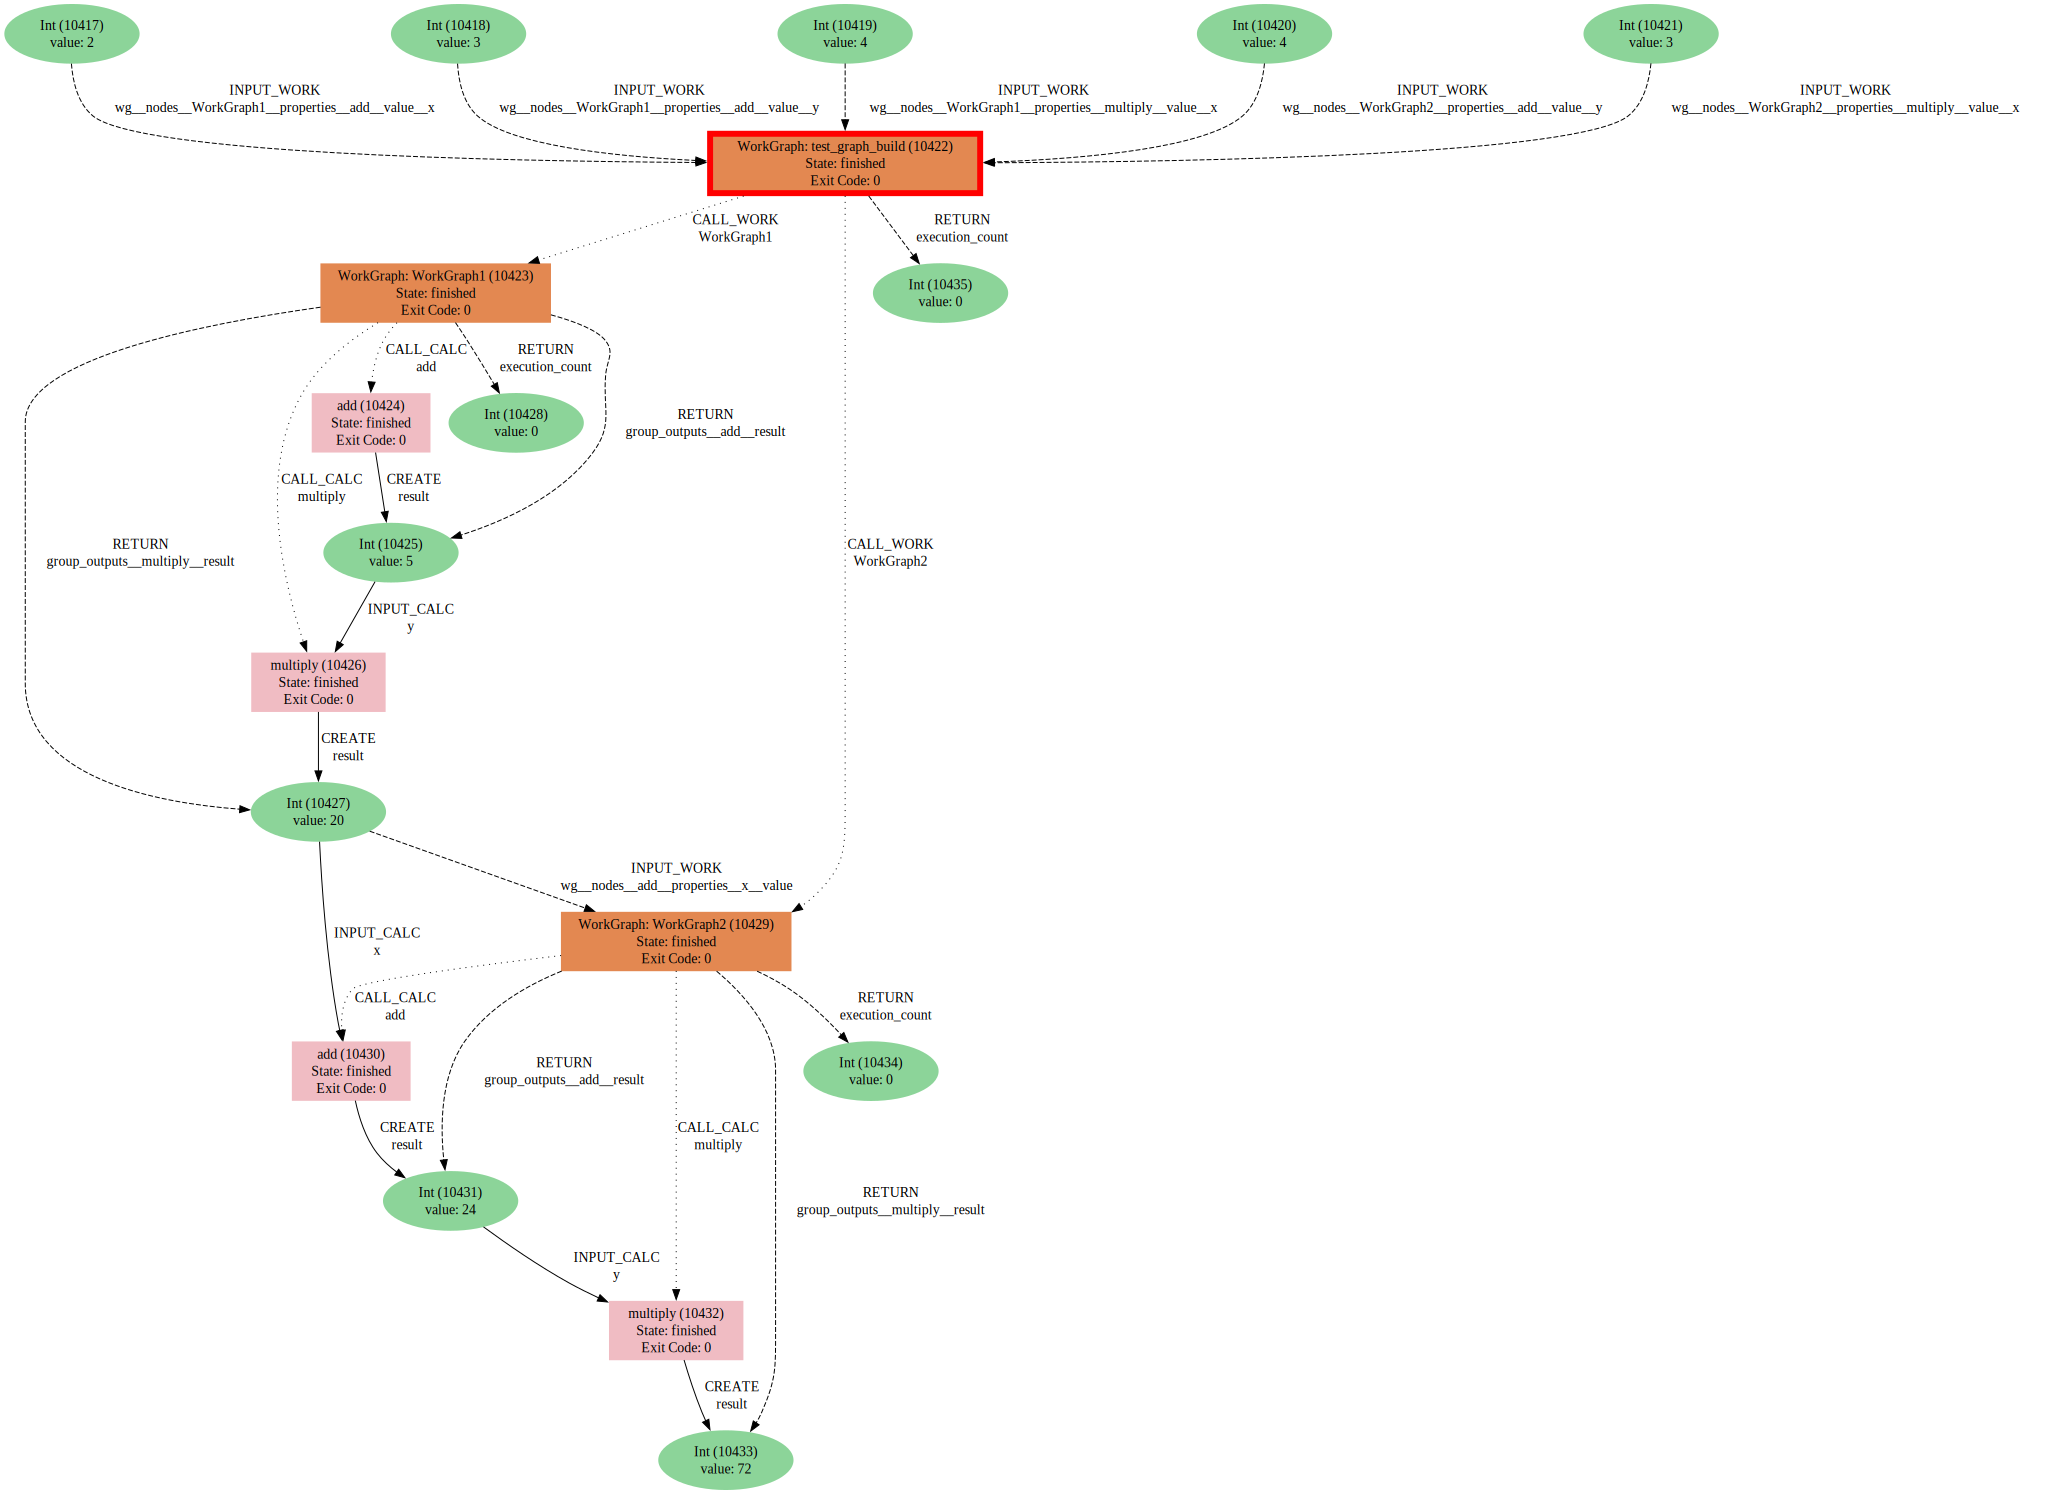

In [19]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg2.pk)

More usage (like `if` and `while`) of graph builder will be shown in the following tutorials.